# Setting Up

## Import Dependencies

In [12]:
import pandas as pd
import gzip
import json
import nltk
from nltk.corpus import stopwords
import emoji
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nedaelewa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nedaelewa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True


## Defining Constants and Truths

In [2]:
DATA_PATH = '../data/'
LABELS = ['art', 'entertainment', 'fashion', 'food', 'gaming', 'health and lifestyle', 'mom and children', 'sports'
          , 'tech', 'travel'] # labels for the accounts
KNOWN_ACCOUNTS = dict() # map usernames to their labels
KNOWN_POST_LIKES = dict() # map post ids to their likes
ACCOUNTS_POSTS = dict() # map usernames to their posts
ACCOUNTS_IDS = dict() # map usernames to their ids
POSTS = dict() # map post ids to their content
USERNAME_DETAILS = dict() # map usernames to their details
POST_TO_ACCOUNT = dict() # map post ids to their usernames

# Data Preprocessing

## Data Loading

In [3]:
# Load the known accounts

with gzip.open(DATA_PATH + 'training/training-dataset.jsonl.gz', 'rt') as f:
    dataset = [json.loads(line) for line in f]

print('Information about the dataset:')
print('Number of accounts:', len(dataset))
print('Type: ', type(dataset))
print('Keys:', dataset[0].keys())
print('Example:', dataset[0])

Information about the dataset:
Number of accounts: 5415
Type:  <class 'list'>
Keys: dict_keys(['profile', 'posts'])
Example: {'profile': {'username': 'deparmedya', 'id': '3170700063', 'full_name': 'Depar Medya', 'biography': '#mediaplanning #mediabuying #sosyalmedya', 'category_name': 'Local business', 'post_count': None, 'follower_count': 1167, 'following_count': 192, 'is_business_account': True, 'is_private': False, 'is_verified': False, 'highlight_reel_count': 6, 'bio_links': '"[{\'title\': \'\', \'lynx_url\': \'https://l.instagram.com/?u=http%3A%2F%2Fwww.deparmedya.com%2F&e=AT31HasgARgPeShR04-FuJmNiVuIQs9QexXBXhEPSCA0mp7gmyAofqi8YDvLKAqZ0zRdO4QFsllkZeR9cLqkyC747QgTHmoA\', \'url\': \'http://www.deparmedya.com/\', \'link_type\': \'external\'}]"', 'entities': '#mediaplanning #mediabuying #sosyalmedya', 'ai_agent_type': None, 'fb_profile_biolink': None, 'restricted_by_viewer': None, 'country_block': False, 'eimu_id': '110133017051179', 'external_url': 'http://www.deparmedya.com/', 'fbi

In [4]:
# Load the training data for classification

training_classification_df = pd.read_csv(DATA_PATH + 'training/train-classification.csv')
training_classification_df.rename(columns={'Unnamed: 0': 'username'}, inplace=True)

print('Information about the training data for classification:')
print(training_classification_df.describe())
training_classification_df.head(5)

Information about the training data for classification:
             username label
count            2742  2742
unique           2742    11
top     taskirancemal  Food
freq                1   511


,username,label
0,taskirancemal,Mom and Children
1,tam_kararinda,Food
2,spart4nn,Food
3,sosyalyiyiciler,Food
4,sonaydizdarahad,Mom and Children


In [6]:
training_classification_df.isnull().sum()
print('Missing values in the training data:\n' + str(training_classification_df.isnull().sum()))

Missing values in the training data:
username    0
label       0
dtype: int64


In [7]:
# Set as strings

training_classification_df['username'] = training_classification_df['username'].astype(str)
training_classification_df['label'] = training_classification_df['label'].astype(str)

In [14]:
# Loading testing data

testing_classification = []

with open(DATA_PATH + 'testing/test-classification-round1.dat', 'r') as f:
    for line in f:
        testing_classification.append(line.strip())

with open(DATA_PATH + 'testing/test-regression-round1.jsonl', 'r') as f:
    testing_regression = [json.loads(line) for line in f]
    testing_regression = pd.DataFrame(testing_regression)

In [15]:
# Information about the testing data

print('Information about the testing data:')
print('Number of accounts:', len(testing_classification))
print('Type:', type(testing_classification))
print('Keys:', testing_regression.keys())
print('Example:')
testing_regression.head(5)


Information about the testing data:
Number of accounts: 1000
Type: <class 'list'>
Keys: Index(['caption', 'comments_count', 'id', 'media_type', 'media_url',
       'timestamp', 'username'],
      dtype='object')
Example:


,caption,comments_count,id,media_type,media_url,timestamp,username
0,"KOZA 2023 2.si Damla’nın koleksiyonu, Latinced...",2,18144550534306740,CAROUSEL_ALBUM,https://scontent-sof1-1.cdninstagram.com/v/t51...,2023-11-02 15:49:22,kozayarismasi
1,Tüm Türkiye ve Avrupa’ya sevkiyatlarımız aralı...,0,17995331788956693,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-19 13:46:02,celikbeymobilya
2,🤩\n\n.\n.\nDaha Fazlası İçin Beğenmeyi ve Taki...,75,18302703232191518,VIDEO,None,2023-10-02 06:53:33,girisimci_muhendis
3,En taze mezelerin en keyifli masalarda buluştu...,1,17908564031282979,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t51...,2022-01-31 12:02:05,levanteculina
4,Psikolojik güvenliği kısaca herhangi bir takım...,0,17952070292635946,IMAGE,https://scontent-sof1-2.cdninstagram.com/v/t51...,2023-06-30 08:46:05,acmagile


In [16]:
# Populating Ground Truths

for i, row in training_classification_df.iterrows():
    KNOWN_ACCOUNTS[row['username']] = row['label']

for entry in dataset:
    username = entry['profile']['username']
    USERNAME_DETAILS[username] = entry['profile']
    ACCOUNTS_IDS[username] = entry['profile']['id']
    ACCOUNTS_POSTS[username] = entry['posts']
    
    for post in entry['posts']:
        post_id = post['id']
        POST_TO_ACCOUNT[post_id] = username
        POSTS[post_id] = post
        if 'like_count' in post:
            KNOWN_POST_LIKES[post_id] = post['like_count']
        else:
            KNOWN_POST_LIKES[post_id] = 0

In [17]:
# Display Sample Data

print('Sample Data:')

print('\nKnown Accounts:\n')
for i, (key, value) in enumerate(KNOWN_ACCOUNTS.items()):
    print(key, value)
    if i == 2:
        break

print('\nKnown Post Likes:\n')
for i, (key, value) in enumerate(KNOWN_POST_LIKES.items()):
    print(key, value)
    if i == 2:
        break

print('\nAccounts Posts:\n')
for i, (key, value) in enumerate(ACCOUNTS_POSTS.items()):
    print(key, value)
    if i == 2:
        break

print('\nAccounts IDs:\n')
for i, (key, value) in enumerate(ACCOUNTS_IDS.items()):
    print(key, value)
    if i == 2:
        break

print('\nPosts:\n')
for i, (key, value) in enumerate(POSTS.items()):
    print(key, value)
    if i == 2:
        break

print('\nUsername Details:\n')
for i, (key, value) in enumerate(USERNAME_DETAILS.items()):
    print(key, value)
    if i == 2:
        break

Sample Data:

Known Accounts:

taskirancemal Mom and Children
tam_kararinda Food
spart4nn Food

Known Post Likes:

17990918969458720 6
18219250732221045 22
18311380465102328 19

Accounts Posts:

deparmedya [{'caption': 'Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷', 'comments_count': 0, 'id': '17990918969458720', 'like_count': 6, 'media_type': 'IMAGE', 'media_url': 'https://scontent-sof1-2.cdninstagram.com/v/t51.29350-15/396342908_267936919574308_4264417069827989599_n.jpg?_nc_cat=107&ccb=1-7&_nc_sid=c4dd86&_nc_ohc=IynXuQSoOT8AX9RSy20&_nc_ht=scontent-sof1-2.cdninstagram.com&edm=AL-3X8kEAAAA&oh=00_AfA8OKAM0MY9tqg6dw8C8I5TJp4SHPBp-VlNXrFAh2agqg&oe=6563581C', 'timestamp': '2023-10-29 09:12:30'}, {'caption': 'Oriflame Duologi Lansmanı #isveçtengelengüzellik #oriflameilesaçbakımdevrimi', 'comments_count': 1, 'id': '18219250732221045', 'like_count': 22, 'media_type': 'VIDEO', 'media_url': 'https://scontent-sof1-2.cdninstagram.com/o1/v/t16/f1/m82/FB43CFCD94D54CB5DC585E1777FB28B8_video_dashinit.mp

In [18]:
# Check missjnig values

print('Missing values in the training data:\n' + str(training_classification_df.isnull().sum()))
print('\nMissing values in the testing data:\n' + str(testing_regression.isnull().sum()))


Missing values in the training data:
username    0
label       0
dtype: int64

Missing values in the testing data:
caption           119
comments_count      0
id                  0
media_type          0
media_url         206
timestamp           0
username            0
dtype: int64


Which usernames do we not have data for?

In [19]:
count = 0
for key, value in KNOWN_ACCOUNTS.items():
    if key not in USERNAME_DETAILS:
        count += 1
        print(key, value)

print('Number of accounts in the training data that are not in the dataset:', count)

orhanelibelediyesi Health and Lifestyle
Number of accounts in the training data that are not in the dataset: 1


In [20]:
# Drop "orhanelibelediyesi" from the training data

training_classification_df = training_classification_df[training_classification_df['username'] != 'orhanelibelediyesi']

In [21]:
# Merge username details with the training data

training_classification_df = training_classification_df.merge(pd.DataFrame(USERNAME_DETAILS).T, left_on='username', right_index=True)

print('Information about the training data after merging with the username details:')
print(training_classification_df.describe())
training_classification_df.head(5)

Information about the training data after merging with the username details:
             username     username_x label     username_y          id  \
count            2741           2741  2741           2741        2741   
unique           2741           2741    11           2741        2741   
top     taskirancemal  taskirancemal  Food  taskirancemal  1282703608   
freq                1              1   511              1           1   

             full_name     biography    category_name  post_count  \
count             2715          2571             2226       275.0   
unique            2715          2565              333       259.0   
top     Cemal Taşkıran  @bigbosslayf  Product/service        79.0   
freq                 1             2              178         3.0   

        follower_count  ...                       business_category_name  \
count             2741  ...                                          268   
unique            2654  ...                                

,username,username_x,label,username_y,id,full_name,biography,category_name,post_count,follower_count,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,taskirancemal,taskirancemal,Mom and Children,taskirancemal,1282703608,Cemal Taşkıran,📍Antalya / Kaş,Entrepreneur,1382.0,12145,...,None,None,None,False,False,https://z-p42-instagram.fsaw1-14.fna.fbcdn.net...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,tam_kararinda,tam_kararinda,Food,tam_kararinda,2114951482,Kaan Yarman,Milliyet Pazar\nKalori Alacaksan Buna Değecek📚,Kitchen/cooking,619.0,783223,...,None,None,None,False,False,https://instagram.fist1-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,spart4nn,spart4nn,Food,spart4nn,645610128,Cemil Ceylan,Küçük ev\nKamp ve doğa hayatı🏕\nMutfağımız doğ...,Video creator,2094.0,1127332,...,None,None,None,False,False,https://z-p42-instagram.fsaw1-12.fna.fbcdn.net...,False,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,sosyalyiyiciler,sosyalyiyiciler,Food,sosyalyiyiciler,1671187359,None,Founder @bitte.izmir \nIZMIR yemek/seyahat foo...,None,919.0,27002,...,None,None,FOOD_COMPANY,False,False,https://instagram.fadb2-2.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,sonaydizdarahad,sonaydizdarahad,Mom and Children,sonaydizdarahad,1635669992,Sonay Demiryeri,DİZDAR 🧿 Ahad 🧿 Dağhan \n@d.a.d.kids \n@dilanp...,Personal blog,2387.0,781362,...,None,None,PERSONAL_BLOG,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [22]:
training_classification_df.isna().sum()

username                                0
username_x                              0
label                                   0
username_y                              0
id                                      0
full_name                              26
biography                             170
category_name                         515
post_count                           2466
follower_count                          0
following_count                         0
is_business_account                     0
is_private                              0
is_verified                             0
highlight_reel_count                    0
bio_links                               0
entities                              170
ai_agent_type                        2741
fb_profile_biolink                   2741
restricted_by_viewer                 2741
country_block                           0
eimu_id                                 0
external_url                          457
fbid                              

In [23]:
COLUMNS_TO_DROP = [ 'username_x',  'username_y',
       'highlight_reel_count', 'bio_links', 'entities', 'ai_agent_type',
       'fb_profile_biolink', 'restricted_by_viewer', 'country_block',
       'eimu_id', 'external_url', 'fbid', 'has_clips',
       'hide_like_and_view_counts', 'is_professional_account',
       'is_supervision_enabled', 'is_guardian_of_viewer',
       'is_supervised_by_viewer', 'is_supervised_user', 'is_embeds_disabled',
       'is_joined_recently', 'business_address_json',
       'business_contact_method', 'business_email', 'business_phone_number',
       'business_category_name', 'category_enum',
       'is_verified_by_mv4b', 'is_regulated_c18', 'profile_pic_url',
       'should_show_category', 'should_show_public_contacts',
       'show_account_transparency_details', 'profile_picture_base64']

training_classification_df.drop(columns=COLUMNS_TO_DROP, inplace=True)

print('Information about the training data after dropping columns:')
print(training_classification_df.describe())
training_classification_df.head(5)

Information about the training data after dropping columns:
             username label          id       full_name     biography  \
count            2741  2741        2741            2715          2571   
unique           2741    11        2741            2715          2565   
top     taskirancemal  Food  1282703608  Cemal Taşkıran  @bigbosslayf   
freq                1   511           1               1             2   

          category_name  post_count  follower_count  following_count  \
count              2226       275.0            2741             2741   
unique              333       259.0            2654              986   
top     Product/service        79.0            1786                0   
freq                178         3.0               3              128   

       is_business_account is_private is_verified overall_category_name  
count                 2741       2741        2741                     0  
unique                   2          2           2                

,username,label,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,is_verified,overall_category_name
0,taskirancemal,Mom and Children,1282703608,Cemal Taşkıran,📍Antalya / Kaş,Entrepreneur,1382.0,12145,1064,False,False,False,None
1,tam_kararinda,Food,2114951482,Kaan Yarman,Milliyet Pazar\nKalori Alacaksan Buna Değecek📚,Kitchen/cooking,619.0,783223,867,False,False,True,None
2,spart4nn,Food,645610128,Cemil Ceylan,Küçük ev\nKamp ve doğa hayatı🏕\nMutfağımız doğ...,Video creator,2094.0,1127332,496,False,False,True,None
3,sosyalyiyiciler,Food,1671187359,None,Founder @bitte.izmir \nIZMIR yemek/seyahat foo...,None,919.0,27002,4279,True,False,False,None
4,sonaydizdarahad,Mom and Children,1635669992,Sonay Demiryeri,DİZDAR 🧿 Ahad 🧿 Dağhan \n@d.a.d.kids \n@dilanp...,Personal blog,2387.0,781362,1877,True,False,True,None


In [24]:
training_classification_df.isna().sum()

username                    0
label                       0
id                          0
full_name                  26
biography                 170
category_name             515
post_count               2466
follower_count              0
following_count             0
is_business_account         0
is_private                  0
is_verified                 0
overall_category_name    2741
dtype: int64

In [25]:
training_classification_df.drop(columns=['overall_category_name', 'post_count'], inplace=True)

In [26]:
user_combined_text = dict()

for post_id, post in POSTS.items():
    username = POST_TO_ACCOUNT[post_id]
    combined_text = " "
    if 'caption' in post:
        if post['caption'] is not None:
            combined_text += post['caption']
    if username not in user_combined_text:
        user_combined_text[username] = " "
    user_combined_text[username] += combined_text

In [27]:
# Add combined text to the training data

training_classification_df['combined_text'] = training_classification_df['username'].map(user_combined_text)

training_classification_df.head(5)

,username,label,id,full_name,biography,category_name,follower_count,following_count,is_business_account,is_private,is_verified,combined_text
0,taskirancemal,Mom and Children,1282703608,Cemal Taşkıran,📍Antalya / Kaş,Entrepreneur,12145,1064,False,False,False,Ah Merve ah.. #tineco #temizlik Çocukken bak...
1,tam_kararinda,Food,2114951482,Kaan Yarman,Milliyet Pazar\nKalori Alacaksan Buna Değecek📚,Kitchen/cooking,783223,867,False,False,True,Faydasız Deneyler Serisi’nde bu sefer blende...
2,spart4nn,Food,645610128,Cemil Ceylan,Küçük ev\nKamp ve doğa hayatı🏕\nMutfağımız doğ...,Video creator,1127332,496,False,False,True,Kütük ocağında et fajita...\n#nature#dinner#...
3,sosyalyiyiciler,Food,1671187359,None,Founder @bitte.izmir \nIZMIR yemek/seyahat foo...,None,27002,4279,True,False,False,Keşif gibi keşifle geldim!cosi.gastro Çakall...
4,sonaydizdarahad,Mom and Children,1635669992,Sonay Demiryeri,DİZDAR 🧿 Ahad 🧿 Dağhan \n@d.a.d.kids \n@dilanp...,Personal blog,781362,1877,True,False,True,Her şeye EYVALLAH 🤐 🤍 10.yıl ❤️ Şanlıurfa da...


In [28]:
# Add full name, category_name, biography to combined text if they are not null

# Convert to strings

training_classification_df['full_name'] = training_classification_df['full_name'].astype(str)
training_classification_df['category_name'] = training_classification_df['category_name'].astype(str)
training_classification_df['biography'] = training_classification_df['biography'].astype(str)
training_classification_df['combined_text'] = training_classification_df['combined_text'].astype(str)

for i, row in training_classification_df.iterrows():
    combined_text = row['combined_text']
    if row['full_name'] is not None and row['full_name'] != 'nan':
        combined_text += ' ' + row['full_name']
    if row['category_name'] is not None and row['category_name'] != 'nan':
        combined_text += ' ' + row['category_name']
    if row['biography'] is not None and row['biography'] != 'nan':
        combined_text += ' ' + row['biography']
    training_classification_df.at[i, 'combined_text'] = combined_text.strip().replace('  ', ' ')

training_classification_df.head(5)

,username,label,id,full_name,biography,category_name,follower_count,following_count,is_business_account,is_private,is_verified,combined_text
0,taskirancemal,Mom and Children,1282703608,Cemal Taşkıran,📍Antalya / Kaş,Entrepreneur,12145,1064,False,False,False,Ah Merve ah.. #tineco #temizlik Çocukken baktı...
1,tam_kararinda,Food,2114951482,Kaan Yarman,Milliyet Pazar\nKalori Alacaksan Buna Değecek📚,Kitchen/cooking,783223,867,False,False,True,Faydasız Deneyler Serisi’nde bu sefer blender’...
2,spart4nn,Food,645610128,Cemil Ceylan,Küçük ev\nKamp ve doğa hayatı🏕\nMutfağımız doğ...,Video creator,1127332,496,False,False,True,Kütük ocağında et fajita...\n#nature#dinner#la...
3,sosyalyiyiciler,Food,1671187359,None,Founder @bitte.izmir \nIZMIR yemek/seyahat foo...,None,27002,4279,True,False,False,Keşif gibi keşifle geldim!cosi.gastro Çakallı ...
4,sonaydizdarahad,Mom and Children,1635669992,Sonay Demiryeri,DİZDAR 🧿 Ahad 🧿 Dağhan \n@d.a.d.kids \n@dilanp...,Personal blog,781362,1877,True,False,True,Her şeye EYVALLAH 🤐 🤍 10.yıl ❤️ Şanlıurfa da E...


In [29]:
training_classification_df.isna().sum()

username               0
label                  0
id                     0
full_name              0
biography              0
category_name          0
follower_count         0
following_count        0
is_business_account    0
is_private             0
is_verified            0
combined_text          0
dtype: int64

In [30]:
# Scale numerical features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_classification_df[['follower_count', 'following_count']] = scaler.fit_transform(training_classification_df[['follower_count', 'following_count']])
training_classification_df.head(5)

,username,label,id,full_name,biography,category_name,follower_count,following_count,is_business_account,is_private,is_verified,combined_text
0,taskirancemal,Mom and Children,1282703608,Cemal Taşkıran,📍Antalya / Kaş,Entrepreneur,-0.050865,0.616689,False,False,False,Ah Merve ah.. #tineco #temizlik Çocukken baktı...
1,tam_kararinda,Food,2114951482,Kaan Yarman,Milliyet Pazar\nKalori Alacaksan Buna Değecek📚,Kitchen/cooking,0.075421,0.409158,False,False,True,Faydasız Deneyler Serisi’nde bu sefer blender’...
2,spart4nn,Food,645610128,Cemil Ceylan,Küçük ev\nKamp ve doğa hayatı🏕\nMutfağımız doğ...,Video creator,0.131779,0.018326,False,False,True,Kütük ocağında et fajita...\n#nature#dinner#la...
3,sosyalyiyiciler,Food,1671187359,None,Founder @bitte.izmir \nIZMIR yemek/seyahat foo...,None,-0.048431,4.003552,True,False,False,Keşif gibi keşifle geldim!cosi.gastro Çakallı ...
4,sonaydizdarahad,Mom and Children,1635669992,Sonay Demiryeri,DİZDAR 🧿 Ahad 🧿 Dağhan \n@d.a.d.kids \n@dilanp...,Personal blog,0.075116,1.473150,True,False,True,Her şeye EYVALLAH 🤐 🤍 10.yıl ❤️ Şanlıurfa da E...


In [36]:
# Map False to 0 and True to 1

training_classification_df['is_private'] = training_classification_df['is_private'].map({False: 0, True: 1})
training_classification_df['is_business_account'] = training_classification_df['is_business_account'].map({False: 0, True: 1})
training_classification_df['is_verified'] = training_classification_df['is_verified'].map({False: 0, True: 1})

In [37]:
training_classification_df.head(5)

,username,label,id,full_name,biography,category_name,follower_count,following_count,is_business_account,is_private,is_verified,combined_text
0,taskirancemal,Mom and Children,1282703608,Cemal Taşkıran,📍Antalya / Kaş,Entrepreneur,-0.050865,0.616689,0,0,0,Ah Merve ah.. #tineco #temizlik Çocukken baktı...
1,tam_kararinda,Food,2114951482,Kaan Yarman,Milliyet Pazar\nKalori Alacaksan Buna Değecek📚,Kitchen/cooking,0.075421,0.409158,0,0,1,Faydasız Deneyler Serisi’nde bu sefer blender’...
2,spart4nn,Food,645610128,Cemil Ceylan,Küçük ev\nKamp ve doğa hayatı🏕\nMutfağımız doğ...,Video creator,0.131779,0.018326,0,0,1,Kütük ocağında et fajita...\n#nature#dinner#la...
3,sosyalyiyiciler,Food,1671187359,None,Founder @bitte.izmir \nIZMIR yemek/seyahat foo...,None,-0.048431,4.003552,1,0,0,Keşif gibi keşifle geldim!cosi.gastro Çakallı ...
4,sonaydizdarahad,Mom and Children,1635669992,Sonay Demiryeri,DİZDAR 🧿 Ahad 🧿 Dağhan \n@d.a.d.kids \n@dilanp...,Personal blog,0.075116,1.473150,1,0,1,Her şeye EYVALLAH 🤐 🤍 10.yıl ❤️ Şanlıurfa da E...


In [38]:
training_classification_df.drop(columns=['full_name', 'category_name', 'biography', 'id'], inplace=True)

In [39]:
training_classification_df.head()

,username,label,follower_count,following_count,is_business_account,is_private,is_verified,combined_text
0,taskirancemal,Mom and Children,-0.050865,0.616689,0,0,0,Ah Merve ah.. #tineco #temizlik Çocukken baktı...
1,tam_kararinda,Food,0.075421,0.409158,0,0,1,Faydasız Deneyler Serisi’nde bu sefer blender’...
2,spart4nn,Food,0.131779,0.018326,0,0,1,Kütük ocağında et fajita...\n#nature#dinner#la...
3,sosyalyiyiciler,Food,-0.048431,4.003552,1,0,0,Keşif gibi keşifle geldim!cosi.gastro Çakallı ...
4,sonaydizdarahad,Mom and Children,0.075116,1.473150,1,0,1,Her şeye EYVALLAH 🤐 🤍 10.yıl ❤️ Şanlıurfa da E...


In [40]:
# add username to the combined text

training_classification_df['combined_text'] = training_classification_df['username'] + ' ' + training_classification_df['combined_text']

# drop username

training_classification_df.drop(columns=['username'], inplace=True)

In [41]:
training_classification_df.head(5)

,label,follower_count,following_count,is_business_account,is_private,is_verified,combined_text
0,Mom and Children,-0.050865,0.616689,0,0,0,taskirancemal Ah Merve ah.. #tineco #temizlik ...
1,Food,0.075421,0.409158,0,0,1,tam_kararinda Faydasız Deneyler Serisi’nde bu ...
2,Food,0.131779,0.018326,0,0,1,spart4nn Kütük ocağında et fajita...\n#nature#...
3,Food,-0.048431,4.003552,1,0,0,sosyalyiyiciler Keşif gibi keşifle geldim!cosi...
4,Mom and Children,0.075116,1.473150,1,0,1,sonaydizdarahad Her şeye EYVALLAH 🤐 🤍 10.yıl ❤...


In [42]:
def preprocess_text(text):
    """Enhanced preprocessing for post content."""
    text = text.casefold()  # Lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = emoji.demojize(text)  # Convert emojis to text
    text = re.sub(r'[^a-zçğıöşü\s]', '', text)  # Keep letters, digits, and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace

    # Optional: Remove stopwords (e.g., Turkish stopwords)
    turkish_stopwords = set(stopwords.words('turkish'))
    text = ' '.join([word for word in text.split() if word not in turkish_stopwords])

    return text

training_classification_df['combined_text'] = training_classification_df['combined_text'].apply(preprocess_text)

In [43]:
# Check if we have any missing values or nan values

print('Missing values in the training data:\n' + str(training_classification_df.isnull().sum()))
print('Nan values in the training data:\n' + str(training_classification_df.isna().sum()))

Missing values in the training data:
label                  0
follower_count         0
following_count        0
is_business_account    0
is_private             0
is_verified            0
combined_text          0
dtype: int64
Nan values in the training data:
label                  0
follower_count         0
following_count        0
is_business_account    0
is_private             0
is_verified            0
combined_text          0
dtype: int64


In [45]:
import numpy as np

# Feature extraction functions
def extract_features(text):
    words = text.split()
    num_words = len(words)
    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    num_unique_words = len(set(words))
    return [num_words, avg_word_length, num_unique_words]

# Apply feature extraction
statistical_features = training_classification_df['combined_text'].apply(extract_features)

# Convert to a DataFrame for easier integration
stat_features_df = pd.DataFrame(statistical_features.tolist(), columns=['num_words', 'avg_word_length', 'num_unique_words'])

#scale the features

scaler = StandardScaler()

stat_features_df = pd.DataFrame(scaler.fit_transform(stat_features_df), columns=stat_features_df.columns)

# Combine the features with the training data

training_classification_df = pd.concat([training_classification_df, stat_features_df], axis=1)

# Set as float

training_classification_df['num_words'] = training_classification_df['num_words'].astype(float)
training_classification_df['avg_word_length'] = training_classification_df['avg_word_length'].astype(float)
training_classification_df['num_unique_words'] = training_classification_df['num_unique_words'].astype(float)

print('Information about the training data after adding statistical features:')

print(training_classification_df.describe())

training_classification_df.head(5)

Information about the training data after adding statistical features:
       follower_count  following_count  is_business_account   is_private  \
count    2.741000e+03     2.741000e+03          2741.000000  2741.000000   
mean    -9.072965e-18    -2.592276e-17             0.719445     0.000365   
std      1.000182e+00     1.000182e+00             0.449352     0.019101   
min     -5.285067e-02    -5.041883e-01             0.000000     0.000000   
25%     -5.228989e-02    -4.957606e-01             0.000000     0.000000   
50%     -5.064049e-02    -4.241256e-01             1.000000     0.000000   
75%     -4.221362e-02     6.889206e-02             1.000000     0.000000   
max      5.093368e+01     7.410430e+00             1.000000     1.000000   

       is_verified     num_words  avg_word_length  num_unique_words  
count  2741.000000  2.741000e+03     2.741000e+03      2.741000e+03  
mean      0.233491 -1.088756e-16    -8.710046e-16     -6.221461e-17  
std       0.423129  1.000182e+00  

,label,follower_count,following_count,is_business_account,is_private,is_verified,combined_text,num_words,avg_word_length,num_unique_words
0,Mom and Children,-0.050865,0.616689,0.0,0.0,0.0,taskirancemal ah merve ah tineco temizlik çocu...,0.581494,-0.604806,1.478112
1,Food,0.075421,0.409158,0.0,0.0,1.0,tamkararinda faydasız deneyler serisinde sefer...,2.515099,-0.952533,2.205911
2,Food,0.131779,0.018326,0.0,0.0,1.0,spartnn kütük ocağında et fajita naturedinnerl...,-0.787090,1.989800,-0.418729
3,Food,-0.048431,4.003552,1.0,0.0,0.0,sosyalyiyiciler keşif keşifle geldimcosigastro...,-0.096774,-0.208285,0.745242
4,Mom and Children,0.075116,1.473150,1.0,0.0,1.0,sonaydizdarahad şeye eyvallah zippermouthface ...,-1.008761,0.006911,-0.872652


In [47]:
# check nan or missing values

print('Missing values in the training data:\n' + str(training_classification_df.isnull().sum()))

print('Nan values in the training data:\n' + str(training_classification_df.isna().sum()))

# drop missing values

training_classification_df.dropna(inplace=True)

Missing values in the training data:
label                  1
follower_count         1
following_count        1
is_business_account    1
is_private             1
is_verified            1
combined_text          1
num_words              1
avg_word_length        1
num_unique_words       1
dtype: int64
Nan values in the training data:
label                  1
follower_count         1
following_count        1
is_business_account    1
is_private             1
is_verified            1
combined_text          1
num_words              1
avg_word_length        1
num_unique_words       1
dtype: int64


In [49]:
# check nan or missing values

print('Missing values in the training data:\n' + str(training_classification_df.isnull().sum()))


Missing values in the training data:
label                  0
follower_count         0
following_count        0
is_business_account    0
is_private             0
is_verified            0
combined_text          0
num_words              0
avg_word_length        0
num_unique_words       0
dtype: int64


In [50]:
training_classification_df['combined_text'] = training_classification_df['combined_text'].astype(str)

In [51]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=6000,  # Limit to top 10,000 features
    ngram_range=(1, 3),  # Use unigrams and bigrams
    stop_words=stopwords.words('turkish') + stopwords.words('english'),  # Optional: use built-in stopwords
    sublinear_tf=True  # Scale term frequency logarithmically
)

# Transform the combined_text column
X_text = vectorizer.fit_transform(training_classification_df['combined_text'])

print(f"TF-IDF matrix shape: {X_text.shape}")

TF-IDF matrix shape: (2740, 6000)


In [ ]:
# Convert to a DataFrame for easier integration

X_text_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())

X_text_df.head(5)

,abdullah,abone,abs,accompanied,acele,acil,acil şifalar,activities,acı,ad,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şık,şık bir,şıklık,şıklığı
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.076234,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.043051,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
X_text_df.describe()

,abdullah,abone,abs,accompanied,acele,acil,acil şifalar,activities,acı,ad,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şık,şık bir,şıklık,şıklığı
count,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000,...,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000
mean,0.001300,0.001363,0.000509,0.001064,0.001225,0.003417,0.001774,0.001107,0.002387,0.001352,...,0.001044,0.001337,0.001038,0.001462,0.002493,0.001383,0.005478,0.001231,0.002044,0.001973
std,0.010555,0.011216,0.007995,0.008830,0.009371,0.013198,0.009968,0.008464,0.012374,0.013663,...,0.011887,0.010320,0.009483,0.009551,0.012046,0.009065,0.020262,0.009841,0.012984,0.012785
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.200975,0.202757,0.256704,0.158750,0.149511,0.131243,0.110147,0.124417,0.162802,0.299065,...,0.279879,0.172312,0.261944,0.155897,0.131600,0.125555,0.232641,0.189899,0.211544,0.202407


In [57]:
# Add a small constant to avoid log(0)
X_text_log = np.log1p(X_text.toarray())  # Applies log(1 + x) transformation element-wise

# Convert back to DataFrame for integration
X_text_log_df = pd.DataFrame(X_text_log, columns=vectorizer.get_feature_names_out())

X_text_log_df.head(5)

,abdullah,abone,abs,accompanied,acele,acil,acil şifalar,activities,acı,ad,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şık,şık bir,şıklık,şıklığı
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.073468,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.04215,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Select metadata features
metadata_features = ['follower_count', 'following_count', 'is_business_account', 'is_private', 'is_verified', 'num_words', 'avg_word_length', 'num_unique_words']

# Normalize numeric metadata
scaler = StandardScaler()
X_metadata = scaler.fit_transform(training_classification_df[metadata_features])

print(f"Metadata matrix shape: {X_metadata.shape}")

Metadata matrix shape: (2740, 8)


In [59]:
feature_names = vectorizer.get_feature_names_out()
print("Sample n-grams:", feature_names[:10])

Sample n-grams: ['abdullah' 'abone' 'abs' 'accompanied' 'acele' 'acil' 'acil şifalar'
 'activities' 'acı' 'ad']


In [62]:
from scipy.sparse import hstack, csr_matrix

# Convert to sparse matrix
X_text_log_sparse = csr_matrix(X_text_log)

# Combine TF-IDF features and metadata
X = hstack([X_text_log_sparse, X_metadata])  # Combine sparse and dense matrices

print(f"Final feature matrix shape: {X.shape}")

Final feature matrix shape: (2740, 6008)


In [63]:
from sklearn.preprocessing import LabelEncoder

y = training_classification_df['label'].astype(str)  # Convert labels to strings

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(training_classification_df['label'])

print(f"Encoded labels shape: {y.shape}")

Encoded labels shape: (2740,)


In [64]:
print("Label classes:", label_encoder.classes_)
print("Type of label classes:", type(label_encoder.classes_[0]))

Label classes: ['Art' 'Entertainment' 'Fashion' 'Food' 'Gaming' 'Health and Lifestyle'
 'Health and lifestyle' 'Mom and Children' 'Sports' 'Tech' 'Travel']
Type of label classes: <class 'str'>


In [65]:
print("Updated Label classes:", label_encoder.classes_)

Updated Label classes: ['Art' 'Entertainment' 'Fashion' 'Food' 'Gaming' 'Health and Lifestyle'
 'Health and lifestyle' 'Mom and Children' 'Sports' 'Tech' 'Travel']


In [66]:
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Feature matrix shape: (2740, 6008)
Labels shape: (2740,)


In [67]:
import pickle

with open('features_and_labels.pkl', 'wb') as f:
    pickle.dump({'X': X, 'y': y}, f)

In [68]:
# Check for NaN values in X_train
X_dense = X.toarray() if hasattr(X, 'toarray') else X  # Convert to dense if it's a sparse matrix
print("NaN values in X_train:", np.isnan(X_dense).sum())

# Check for NaN values in each column
if isinstance(X_dense, pd.DataFrame):  # If X_train is a DataFrame
    print("Columns with NaN values:")
    print(X_dense.isnull().sum())

NaN values in X_train: 0


In [69]:
print("Label classes:", label_encoder.classes_)
print("Type of label classes:", type(label_encoder.classes_[0]))

Label classes: ['Art' 'Entertainment' 'Fashion' 'Food' 'Gaming' 'Health and Lifestyle'
 'Health and lifestyle' 'Mom and Children' 'Sports' 'Tech' 'Travel']
Type of label classes: <class 'str'>


In [71]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


def generate_report(model, X_train, y_train, X_test, y_test, label_encoder):
    # Training Metrics
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_report = classification_report(y_train, y_train_pred, target_names=label_encoder.classes_)

    # Test Metrics
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred, target_names=label_encoder.classes_)

    print("=== Training Metrics ===")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(train_report)

    print("\n=== Test Metrics ===")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(test_report)

    # Confusion Matrix for Test Data
    cm = confusion_matrix(y_test, y_test_pred, labels=range(len(label_encoder.classes_)))
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix - Test Data")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Ensure combined_text column does not contain NaN values
training_classification_df['combined_text'] = training_classification_df['combined_text'].astype(str)
training_classification_df['combined_text'].fillna('', inplace=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
model = LogisticRegression(max_iter=500, class_weight='balanced')

# Impute missing values in X_train and X_test
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Retrain the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

                      precision    recall  f1-score   support

                 Art       0.55      0.43      0.48        42
       Entertainment       0.47      0.44      0.45        73
             Fashion       0.58      0.66      0.62        58
                Food       0.86      0.80      0.83        97
              Gaming       0.00      0.00      0.00         3
Health and Lifestyle       0.47      0.33      0.39        86
Health and lifestyle       0.22      0.32      0.26        19
    Mom and Children       0.38      0.48      0.43        27
              Sports       0.62      0.70      0.65        23
                Tech       0.58      0.80      0.67        65
              Travel       0.83      0.80      0.81        55

            accuracy                           0.59       548
           macro avg       0.51      0.52      0.51       548
        weighted avg       0.60      0.59      0.59       548



In [73]:
# accuracy, and f1-score

from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.59
F1-score: 0.59


In [74]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs', 'sag'],  # Solvers
    'class_weight': [None, 'balanced']  # Class balancing
}

In [75]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
import numpy as np

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'sag'],
    'class_weight': [None, 'balanced']
}

# Generate all combinations of parameters
param_combinations = list(ParameterGrid(param_grid))
n_combinations = len(param_combinations)

# Initialize variables to track the best model
best_score = 0
best_params = None

# Progress bar
progress = tqdm(total=n_combinations, desc="Hyperparameter Tuning")

# Loop through each combination of parameters
for params in param_combinations:
    model = LogisticRegression(
        max_iter=1000,
        C=params['C'],
        solver=params['solver'],
        class_weight=params['class_weight']
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate on the validation set
    y_val_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_val_pred)
    
    # Update best parameters if this combination is better
    if score > best_score:
        best_score = score
        best_params = params
    
    # Update progress bar
    progress.update(1)

# Close the progress bar
progress.close()

print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_score:.4f}")

Hyperparameter Tuning:  37%|███▋      | 11/30 [00:43<01:12,  3.82s/it]/Users/nedaelewa/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Hyperparameter Tuning:  47%|████▋     | 14/30 [01:06<01:19,  4.99s/it]/Users/nedaelewa/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Hyperparameter Tuning:  57%|█████▋    | 17/30 [01:29<01:09,  5.38s/it]/Users/nedaelewa/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Hyperparameter Tuning:  67%|██████▋   | 20/30 [01:55<01:02,  6.30s/it]/Users/nedaelewa/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

Best Hyperparameters: {'C': 10, 'class_weight': None, 'solver': 'liblinear'}
Best Validation Accuracy: 0.6606


/Users/nedaelewa/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nedaelewa/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nedaelewa/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=== Training Metrics ===
Training Accuracy: 0.9854
                      precision    recall  f1-score   support

                 Art       1.00      0.96      0.98       149
       Entertainment       0.99      0.98      0.99       250
             Fashion       0.97      1.00      0.98       241
                Food       0.99      1.00      0.99       414
              Gaming       1.00      1.00      1.00        10
Health and Lifestyle       0.98      0.97      0.98       332
Health and lifestyle       1.00      1.00      1.00        64
    Mom and Children       0.99      0.98      0.99       122
              Sports       1.00      0.98      0.99        90
                Tech       0.97      1.00      0.99       281
              Travel       0.98      0.98      0.98       239

            accuracy                           0.99      2192
           macro avg       0.99      0.99      0.99      2192
        weighted avg       0.99      0.99      0.99      2192


=== Test Metric

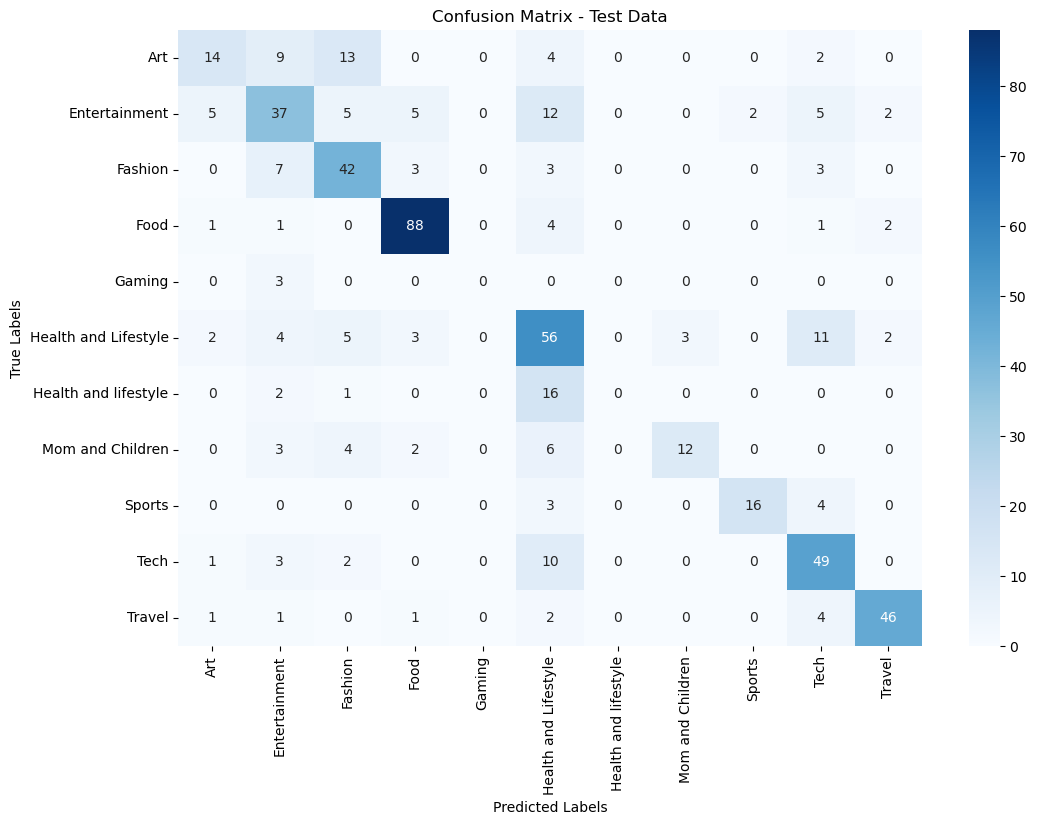

In [81]:
# Use the best hyperparameters
best_model = LogisticRegression(
    max_iter=1000,
    C=7,
    solver=best_params['solver'],
    class_weight=best_params['class_weight']
)

# Fit the model on the training data
best_model.fit(X_train, y_train)

# Training set predictions
y_train_pred = best_model.predict(X_train)

# Test set predictions
y_test_pred = best_model.predict(X_test)

# Generate reports
generate_report(best_model, X_train, y_train, X_test, y_test, label_encoder)

In [82]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-Validation Accuracy: 0.6574 ± 0.0152
